# Demand Forecasting Notebook Summary

This Jupyter Notebook performs a complete **demand forecasting** task. Its main goal is to predict the quantity of different products (SKUs) that will be sold at various locations for the next 7 days.

The process is broken down into three main parts:

### a. Model Training and Evaluation

* In this notebook, I load a dataset of historical sales data (synthetic_demand_data.csv).
* I perform extensive **feature engineering**, creating time-based features (like day of the week) and crucial time-series features like **lags** (sales from 7 and 14 days ago) and **rolling averages**.
* I train an **XGBoost Regressor** model on this enhanced data.
* I properly evaluate the model on a time-based test set, achieving a Mean Absolute Error (MAE) of **8.75**. I also generate a feature importance plot to see what drives the predictions.

### b. Final Model Retraining and Forecasting

* Following best practices, I **retrain the model on the entire dataset** to make it as accurate as possible for future predictions.
* I then perform a **7-day recursive forecast**, where the prediction for each day is used to help generate the features for the next day.

### c. Output Formatting

* Finally, I take the 7-day forecast results and format them into a specific forecast_output.json file. Each entry in the JSON contains a sku_id, a location, and a list of the 7 predicted daily demand quantities.

### 1. Demand Forecasting : EDA, Traning and Testing the data on Test-Train split.

Data loaded successfully.
Initial Data Head:
  order_date    sku_id   location  quantity
0 2025-04-08  mango123     Mumbai        58
1 2025-04-08  mango123      Delhi        33
2 2025-04-08  mango123  Bangalore        25
3 2025-04-08  apple456     Mumbai        73
4 2025-04-08  apple456      Delhi        87

Data after creating time-based features:
  order_date    sku_id   location  quantity  day_of_week  day_of_year  month  \
0 2025-04-08  mango123     Mumbai        58            1           98      4   
1 2025-04-08  mango123      Delhi        33            1           98      4   
2 2025-04-08  mango123  Bangalore        25            1           98      4   
3 2025-04-08  apple456     Mumbai        73            1           98      4   
4 2025-04-08  apple456      Delhi        87            1           98      4   

   week_of_year  
0            15  
1            15  
2            15  
3            15  
4            15  

Data after creating lag and rolling features:
  order_date 

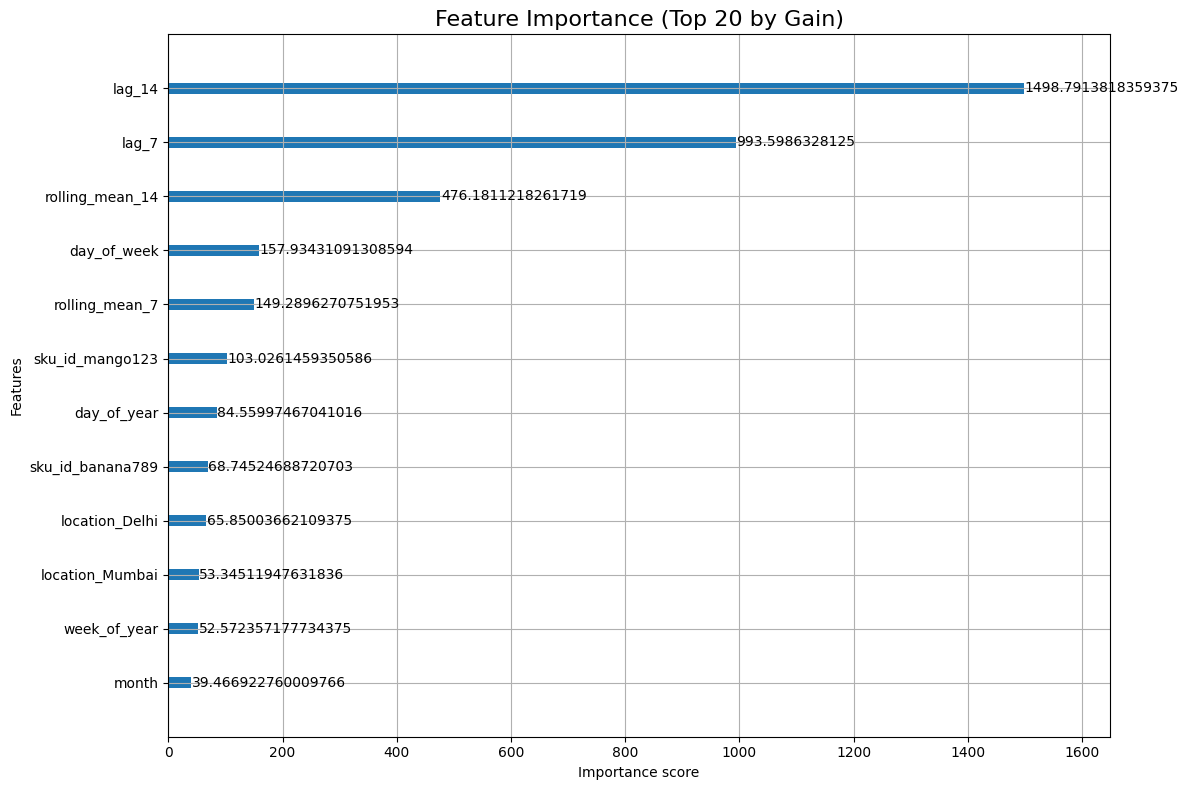

In [4]:
# ==============================================================================
# 1. SETUP: IMPORT LIBRARIES AND LOAD DATA
# ==============================================================================
import pandas as pd
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

# Load the dataset
# The 'order_date' column is parsed into datetime objects upon loading.
try:
    df = pd.read_csv('data/synthetic_demand_data.csv')
    df['order_date'] = pd.to_datetime(df['order_date'])
    print("Data loaded successfully.")
    print("Initial Data Head:")
    print(df.head())
except FileNotFoundError:
    print("Error: synthetic_demand_data.csv not found in the 'data/' directory.")
    # Exit or handle the error appropriately if the file is not found
    exit()

# ==============================================================================
# 2. FEATURE ENGINEERING
# ==============================================================================

# Function to create time-based features from the 'order_date' column.
def create_time_features(df):
    """
    Creates time series features from a datetime index.
    """
    df_copy = df.copy()
    df_copy['day_of_week'] = df_copy['order_date'].dt.dayofweek
    df_copy['day_of_year'] = df_copy['order_date'].dt.dayofyear
    df_copy['month'] = df_copy['order_date'].dt.month
    df_copy['week_of_year'] = df_copy['order_date'].dt.isocalendar().week.astype(int)
    return df_copy

df_featured = create_time_features(df)
print("\nData after creating time-based features:")
print(df_featured.head())


# Function to create lag and rolling window features.
# These are crucial for time series models to understand past trends.
def create_lag_rolling_features(df, drop_na=True):
    """
    Creates lag and rolling window features for sales quantity.
    """
    df_copy = df.copy()
    # Sort data to ensure lags and rolling windows are calculated correctly for each item-location group.
    df_copy = df_copy.sort_values(by=['sku_id', 'location', 'order_date'])

    # Lag features: sales from previous periods (e.g., same day last week).
    # We use groupby to calculate lags per item-location combination.
    df_copy['lag_7'] = df_copy.groupby(['sku_id', 'location'])['quantity'].shift(7)
    df_copy['lag_14'] = df_copy.groupby(['sku_id', 'location'])['quantity'].shift(14)

    # Rolling window features: average sales over a past period.
    # We shift by 1 to prevent data leakage (using the current day's value to predict itself).
    df_copy['rolling_mean_7'] = df_copy.groupby(['sku_id', 'location'])['quantity'].shift(1).rolling(window=7).mean()
    df_copy['rolling_mean_14'] = df_copy.groupby(['sku_id', 'location'])['quantity'].shift(1).rolling(window=14).mean()

    # The initial rows will have NaN values for these new features. We drop them.
    if drop_na:
        df_copy = df_copy.dropna().reset_index(drop=True)

    return df_copy

df_featured = create_lag_rolling_features(df_featured)
print("\nData after creating lag and rolling features:")
print(df_featured.head())

# ==============================================================================
# 3. DATA PREPARATION AND TRAIN-TEST SPLIT
# ==============================================================================

# One-hot encode categorical features ('sku_id', 'location').
# We keep the 'order_date' column for now so we can use it for a time-based split.
df_final = pd.get_dummies(df_featured, columns=['sku_id', 'location'], drop_first=True)

print("\nFinal DataFrame ready for splitting:")
print(df_final.head())

# --- Robust Time-Based Train-Test Split ---
# This is a critical step for time series forecasting to avoid data leakage.
# We train on older data and validate on the most recent data.

# Define the target variable we want to predict.
TARGET = 'quantity'

# Define the cutoff point for the split. We'll use the last 10 days for testing.
cutoff_point = df_final['order_date'].max() - pd.Timedelta(days=10)

# Split the DataFrame into training and testing sets based on the date.
train_df = df_final[df_final['order_date'] <= cutoff_point].copy()
test_df = df_final[df_final['order_date'] > cutoff_point].copy()

# Define the feature columns. We exclude the target variable and the original date column,
# as the date is not a direct input to the model (we've already created features from it).
FEATURES = [col for col in df_final.columns if col not in [TARGET, 'order_date']]

# Create the final training and testing sets.
X_train = train_df[FEATURES]
y_train = train_df[TARGET]

X_test = test_df[FEATURES]
y_test = test_df[TARGET]

print("\n--- Data Shapes ---")
print(f"Training data shape: {X_train.shape}")
print(f"Test data shape:     {X_test.shape}")


# ==============================================================================
# 4. MODEL TRAINING
# ==============================================================================

model = XGBRegressor(
    n_estimators=1000,          # Number of boosting rounds
    learning_rate=0.05,         # Step size shrinkage to prevent overfitting
    max_depth=5,                # Maximum depth of an individual tree
    subsample=0.8,              # Fraction of samples to be used for fitting each tree
    colsample_bytree=0.8,       # Fraction of columns to be used when constructing each tree
    objective='reg:squarederror', # Learning task and objective function
    n_jobs=-1,                  # Use all available CPU threads for training
    random_state=42,
    eval_metric='mae',          # Evaluation metric for early stopping
    early_stopping_rounds=50    # <-- Move this here!
)

print("\nTraining the XGBoost model...")

model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)], # Provide validation sets
    verbose=100 # Print evaluation results every 100 rounds
)

# ==============================================================================
# 5. MODEL EVALUATION AND FEATURE IMPORTANCE
# ==============================================================================

# Make predictions on the test set using the trained model.
y_pred = model.predict(X_test)

# Calculate performance metrics to evaluate the model.
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"\n--- Model Evaluation ---")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

# Plot feature importance to understand which features the model found most predictive.
fig, ax = plt.subplots(figsize=(12, 8))
xgb.plot_importance(model, ax=ax, max_num_features=20, importance_type='gain')
plt.title("Feature Importance (Top 20 by Gain)", fontsize=16)
plt.tight_layout()
plt.show()

### 2. Retraining the model on Full dataset.

In [5]:
# ==============================================================================
# 1. SETUP AND FEATURE ENGINEERING (Prerequisites)
# ==============================================================================
import pandas as pd
import xgboost as xgb
from xgboost import XGBRegressor
from tqdm import tqdm
import numpy as np

# --- Data Loading ---
try:
    df = pd.read_csv('data/synthetic_demand_data.csv')
    df['order_date'] = pd.to_datetime(df['order_date'])
    print("Data loaded successfully.")
except FileNotFoundError:
    print("Error: synthetic_demand_data.csv not found in the 'data/' directory.")
    exit()

# --- Feature Engineering Functions (Required for forecasting loop) ---
def create_time_features(df):
    """Creates time series features from a datetime index."""
    df_copy = df.copy()
    df_copy['day_of_week'] = df_copy['order_date'].dt.dayofweek
    df_copy['day_of_year'] = df_copy['order_date'].dt.dayofyear
    df_copy['month'] = df_copy['order_date'].dt.month
    df_copy['week_of_year'] = df_copy['order_date'].dt.isocalendar().week.astype(int)
    return df_copy

def create_lag_rolling_features(df, drop_na=True):
    """Creates lag and rolling window features for sales quantity."""
    df_copy = df.copy()
    df_copy = df_copy.sort_values(by=['sku_id', 'location', 'order_date'])
    df_copy['lag_7'] = df_copy.groupby(['sku_id', 'location'])['quantity'].shift(7)
    df_copy['lag_14'] = df_copy.groupby(['sku_id', 'location'])['quantity'].shift(14)
    df_copy['rolling_mean_7'] = df_copy.groupby(['sku_id', 'location'])['quantity'].shift(1).rolling(window=7).mean()
    df_copy['rolling_mean_14'] = df_copy.groupby(['sku_id', 'location'])['quantity'].shift(1).rolling(window=14).mean()
    if drop_na:
        df_copy = df_copy.dropna().reset_index(drop=True)
    return df_copy

# --- Create the Full Feature Set (to define X and y) ---
print("Preparing full dataset for final model training...")
# 1. Create initial time features
df_with_time_features = create_time_features(df)
# 2. Create lag/rolling features for the entire dataset
df_featured = create_lag_rolling_features(df_with_time_features)
# 3. One-hot encode the full, featured dataset
df_final = pd.get_dummies(df_featured, columns=['sku_id', 'location'], drop_first=True)

# 4. Define the full X and y for final model training
TARGET = 'quantity'
FEATURES = [col for col in df_final.columns if col not in [TARGET, 'order_date']]
X = df_final[FEATURES]
y = df_final[TARGET]

print(f"Full dataset prepared. Shape of X: {X.shape}, Shape of y: {y.shape}")

# ==============================================================================
# 2. FINAL MODEL TRAINING (Your code starts here)
# ==============================================================================
print("\nRe-training the final model on all available data...")

# Define the final model using XGBoost Regressor
final_model = xgb.XGBRegressor(
    n_estimators=1000,          # Increased estimators for final model
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='reg:squarederror',
    n_jobs=-1,
    random_state=42,
    # For final training, we don't need early stopping as there's no validation set
)

# Fit the model on the entire dataset (X and y defined above)
# We can set verbose=100 to see progress if n_estimators is very large
final_model.fit(X, y, verbose=100)

print("Final model trained successfully.")

# ==============================================================================
# 3. RECURSIVE FORECASTING
# ==============================================================================
print(f"\nSetting up for forecasting...")

# Forecasting parameters
N_FORECAST_DAYS = 7  # Number of future days to forecast
last_date = df['order_date'].max()  # Last known date in the original data
skus = df['sku_id'].unique()  # All unique SKUs
locations = df['location'].unique()  # All unique locations

# Create a future dataframe shell with all combinations of dates, SKUs, and locations
future_dates = [last_date + pd.DateOffset(days=i) for i in range(1, N_FORECAST_DAYS + 1)]
future_df = pd.DataFrame([(d, s, l) for d in future_dates for s in skus for l in locations],
                         columns=['order_date', 'sku_id', 'location'])

# Start the forecasting loop with a copy of the historical data
# We use df_featured as it has the correct structure for creating new features
history_df = df_featured.copy()
predictions_list = []  # A list to store the daily prediction DataFrames

print(f"Generating forecast for the next {N_FORECAST_DAYS} days...")

for day in tqdm(future_dates, desc="Forecasting Progress"):
    # 1. Get the slice of the future we want to predict for this iteration
    current_day_df = future_df[future_df['order_date'] == day]

    # 2. Combine history with the current day's empty shell
    # This allows lag/rolling features to be calculated based on the most recent data
    merged_df = pd.concat([history_df, current_day_df], ignore_index=True)

    # 3. Create features for the combined data
    # IMPORTANT: Use the *original* feature creation functions
    featured_day = create_time_features(merged_df)
    # drop_na=False is crucial here, we need to keep the row we want to predict
    featured_day = create_lag_rolling_features(featured_day, drop_na=False)

    # 4. Isolate the specific day we need to predict
    prediction_input_df = featured_day[featured_day['order_date'] == day].copy()

    # 5. Prepare the data for the model (one-hot encode and align columns)
    prediction_input_df_encoded = pd.get_dummies(prediction_input_df, columns=['sku_id', 'location'], drop_first=True)
    # The .reindex() step is CRITICAL. It ensures the prediction data has the exact same
    # columns in the exact same order as the training data (X), filling missing ones with 0.
    prediction_input_df_encoded = prediction_input_df_encoded.reindex(columns=X.columns, fill_value=0)

    # 6. Make the prediction for the day
    daily_preds = final_model.predict(prediction_input_df_encoded)

    # 7. Store the prediction results and update history for the next loop
    prediction_input_df['quantity'] = np.round(daily_preds).astype(int)
    prediction_input_df['quantity'] = prediction_input_df['quantity'].clip(lower=0) # Ensure no negative quantities

    # Append the newly predicted data to our history_df to be used for the next day's forecast
    history_df = pd.concat([history_df, prediction_input_df[['order_date', 'sku_id', 'location', 'quantity']]], ignore_index=True)
    predictions_list.append(prediction_input_df)

# ==============================================================================
# 4. FINALIZE AND DISPLAY FORECAST
# ==============================================================================
# Combine all the daily prediction DataFrames into a single final forecast
final_forecast_df = pd.concat(predictions_list, ignore_index=True)

print("\n--- Forecast Generation Complete ---")
print("Sample of the generated forecast:")
print(final_forecast_df[['order_date', 'sku_id', 'location', 'quantity']].head())

Data loaded successfully.
Preparing full dataset for final model training...
Full dataset prepared. Shape of X: (414, 12), Shape of y: (414,)

Re-training the final model on all available data...
Final model trained successfully.

Setting up for forecasting...
Generating forecast for the next 7 days...


Forecasting Progress: 100%|██████████| 7/7 [00:00<00:00, 17.62it/s]


--- Forecast Generation Complete ---
Sample of the generated forecast:
  order_date     sku_id   location  quantity
0 2025-06-07   apple456  Bangalore       152
1 2025-06-07   apple456      Delhi       175
2 2025-06-07   apple456     Mumbai       165
3 2025-06-07  banana789  Bangalore        96
4 2025-06-07  banana789      Delhi       136


### 3. Converting forecast into forecast_output.json 

In [6]:
import json

# Assuming 'final_forecast_df' is your DataFrame with the 7-day predictions
# It should look like this:
#    order_date     sku_id   location  quantity
# 0  2025-06-07   apple456  Bangalore       153
# 1  2025-06-07   apple456      Delhi       176
# 2  2025-06-07   apple456     Mumbai       165
# ...

# --- Step 1: Initialize an empty list to hold our JSON objects ---
output_data = []

print("--- Starting JSON formatting ---")

# --- Step 2: Group the DataFrame by SKU and Location ---
# The .groupby() method is perfect for this. It will create a separate group
# for each of the 9 unique combinations (e.g., ('apple456', 'Bangalore')).
grouped = final_forecast_df.groupby(['sku_id', 'location'])

# --- Step 3: Loop through each group to build the JSON objects ---
for (sku, loc), group_df in grouped:
    
    # Ensure the forecasts within each group are in chronological order
    sorted_group = group_df.sort_values('order_date')
    
    # Extract the 'quantity' column and convert it to a simple Python list
    forecast_list = sorted_group['quantity'].tolist()
    
    # Create the dictionary object in the desired format
    output_object = {
        "sku_id": sku,
        "location": loc,
        "forecast_next_7_days": forecast_list
    }
    
    # Add the newly created object to our main list
    output_data.append(output_object)

# --- Step 4: Define the output filename and save the data ---
output_filename = 'forecast_output.json'

try:
    with open(output_filename, 'w') as f:
        # json.dump() writes the Python list of dictionaries to the file
        # indent=4 makes the JSON file human-readable and "pretty"
        json.dump(output_data, f, indent=4)
    
    print(f"\nSUCCESS: Forecast data successfully saved to '{output_filename}'")

except Exception as e:
    print(f"\nERROR: An issue occurred while saving the file: {e}")

# --- Step 5: (Optional but Recommended) Print a sample to verify ---
if output_data:
    print("\n--- Sample of generated JSON ---")
    # json.dumps() converts a Python object to a JSON formatted string for printing
    print(json.dumps(output_data[0], indent=4))

--- Starting JSON formatting ---

SUCCESS: Forecast data successfully saved to 'forecast_output.json'

--- Sample of generated JSON ---
{
    "sku_id": "apple456",
    "location": "Bangalore",
    "forecast_next_7_days": [
        152,
        122,
        116,
        112,
        116,
        122,
        149
    ]
}
